In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
import serial
import time
from picoscope import ps5000a
import picosdk
from picosdk.discover import find_all_units
import serial.tools.list_ports as port_list
import chipwhisperer as cw

# Check if the Picoscope is connected
scopes = find_all_units()
for scope in scopes:
    print("Working with:")
    print(scope.info)
    scope.close()
ports = list(port_list.comports())
for p in ports:
    print (p)


Working with:
UnitInfo(driver=<picosdk.ps5000a.Ps5000alib object at 0x7f527ca07b80>, variant=b'5244D', serial=b'KU687/0175')
/dev/ttyS4 - n/a


**PicoScope setup**

In [2]:
ps = ps5000a.PS5000a()
print("Found the following picoscope:")
print(ps.getAllUnitInfo())

# Since target runnning at 10 MHz and AES requires from trigger
obs_duration = 3.225E-6
# Sample at least 1260 points within that window
sampling_interval = obs_duration / 1260
# Configure timebase
(actualSamplingInterval, nSamples, maxSamples) = ps.setSamplingInterval(sampling_interval, obs_duration)
print("Nsamples : ", nSamples)
print("Sampling interval = %f us" % (actualSamplingInterval*nSamples*1E6))

# 50mV range on channel A, AC coupled, 20 MHz BW limit
ps.setChannel('A', 'AC', 0.05, 0.0, enabled=True, BWLimited=True)
# Channel B is trigger
ps.setChannel('B', 'DC', 10.0, 0.0, enabled=True)
ps.setSimpleTrigger('B', 2.0, 'Rising', timeout_ms=2000, enabled=True)

Found the following picoscope:
DriverVersion                 : PS5000A Linux Driver, 2.1.124.5349
USBVersion                    : 3.0
HardwareVersion               : 1
VariantInfo                   : 5244D
BatchAndSerial                : KU687/0175
CalDate                       : 26Apr23
KernelVersion                 : 0.0
DigitalHardwareVersion        : 1
AnalogueHardwareVersion       : 1
PicoFirmwareVersion1          : 1.7.15.0
PicoFirmwareVersion2          : 1.2.34.0
Nsamples :  1612
Sampling interval = 3.224000 us


**CW305 setup**

In [3]:
TARGET_PLATFORM = 'CW305_100t'
fpga_id = '100t'
target = cw.target(None, cw.targets.CW305, fpga_id=fpga_id, force = True)

print(target.is_programmed())

target.vccint_set(1.0)
target.pll.pll_enable_set(True)         # enable PLL chip
target.pll.pll_outenable_set(False, 0)  # disable PLL 0
target.pll.pll_outenable_set(True, 1)   # enable PLL 1
target.pll.pll_outenable_set(False, 2)  # disable PLL 2
target.pll.pll_outfreq_set(10E6, 1)     # PLL1 frequency set to 10 MHz
# 1 ms is plenty idling time --> maybe not useful with picoscope (?) 
target.clksleeptime = 1 

True


**Capture loop**

In [4]:
def pico_capture():
    # Arm the picoscope
    ps.runBlock()
    time.sleep(0.05)
    # Trigger the encryption on Target
    target.fpga_write(target.REG_USER_LED, [0x01])
    target.usb_trigger_toggle()
    ps.waitReady()
    # Capture the trace 
    data = ps.getDataV('A', nSamples, returnOverflow=False)
    return data

In [5]:
from tqdm.notebook import tnrange
project_file = "sca_test_CW305.cwp"
project = cw.create_project(project_file, overwrite=True)

from Crypto.Cipher import AES
from chipwhisperer.common.traces import Trace

ktp = cw.ktp.Basic()
# Initialize cipher to verify DUT result:
key, text = ktp.next()
cipher = AES.new(bytes(key), AES.MODE_ECB)
print("Key: ", key)

N = 2000        # Number of traces
traces = []
textin = []
keys = []
data_mV = []

target.fpga_write(target.REG_CRYPT_KEY, key[::-1])

# Dummy capture call due to bug of using AC coupling
pico_capture()

for i in tnrange(N, desc='Capturing traces'):
    
    # Write plaintext to target
    inputtext = text[::-1]
    target.fpga_write(target.REG_CRYPT_TEXTIN, inputtext)

    # Capture the trace 
    data = pico_capture()
    traces.append(np.array(data))
    data_mV.append(np.array(data)*1E3)

    # Organize and store data
    response = target.fpga_read(target.REG_CRYPT_CIPHEROUT, 16)
    response = response[::-1]
    trace_i = Trace(np.array(data), text, response, key)
    project.traces.append(trace_i)
    
    # Sanity check with expected ciphertext
    #print("Response fpga: ",[ hex(el) for el in response])
    #print("Expected instead: ", [hex(el) for el in cipher.encrypt(bytes(text))])
    assert (list(response) == list(cipher.encrypt(bytes(text)))), "Incorrect encryption result!\nGot {}\nExp {}\n".format(list(response), list(text))
    
    key, text = ktp.next() 
    textin.append(text)
    keys.append(key)

project.save()
project.close()
target.dis()

Key:  CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


Capturing traces:   0%|          | 0/2000 [00:00<?, ?it/s]

**Plotting trace**

In [6]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import CrosshairTool

output_notebook()
p = figure(plot_width=800)

xrange = range(len(traces[0]))
p.line(xrange, traces[4], line_color="red")
show(p)

Loading BokehJS ...

**Performing AES CPA attack**

In [7]:
import chipwhisperer.analyzer as cwa
import chipwhisperer as cw
project_file = "sca_test_CW305.cwp"
project = cw.open_project(project_file)

In [8]:
attack = cwa.cpa(project, cwa.leakage_models.last_round_state_diff)
cb = cwa.get_jupyter_callback(attack)
results = attack.run(cwa.get_jupyter_callback(attack, 10))

In [9]:
from chipwhisperer.analyzer.attacks.models.aes.key_schedule import key_schedule_rounds
recv_lastroundkey = [kguess[0][0] for kguess in results.find_maximums()]
recv_key = key_schedule_rounds(recv_lastroundkey, 10, 0)
print("Recovered key: ", [hex(subkey) for subkey in recv_key])
key=list(project.keys[0])
assert (key == recv_key), "Failed to recover encryption key!\nGot {}\nExp {}\n".format(recv_key, key)
print("Key recovery : Success!")

Graphical Results

In [10]:
import holoviews as hv
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from holoviews.operation import decimate
import pandas as pd, numpy as np
#plot_data = cwa.analyzer_plots(results)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
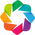

NameError: name 'plot_data' is not defined

In [11]:

def byte_to_color(idx):
    return hv.Palette.colormaps['Category20'](idx/16.0)

a = []
b = []
hv.extension('bokeh')

# display the calculated correlation at each point in time for the coreect key
for key_byte in range(0, 16):
    data = plot_data.output_vs_time(key_byte)
    a.append(np.array(data[1]))
    b.append(np.array(data[2]))
    b.append(np.array(data[3]))

pda = pd.DataFrame(a).transpose().rename(str, axis='columns')
pdb = pd.DataFrame(b).transpose().rename(str, axis='columns')   
curve = hv.Curve(pdb['0'], "Sample").options(color='black')

for key_byte in range(1, 16):
    curve *= hv.Curve(pdb[str(key_byte)]).options(color=byte_to_color(key_byte))

for key_byte in range(0, 16):
    curve *= hv.Curve(pda[str(key_byte)]).options(color=byte_to_color(key_byte))
curve.opts(width=900, height=600)
#decimate(curve.opts(width=900, height=600)) 

In [ ]:
ret = plot_data.pge_vs_trace(0)
curve = hv.Curve((ret[0], ret[1], "Traces Used in Calculation", "Partial Guessing Entropy of Byte"))

for bnum in range(1,16):
    ret = plot_data.pge_vs_trace(bnum)
    curve *= hv.Curve((ret[0], ret[1])).opts(color=byte_to_color(bnum))
curve.opts(width=900, height=600)

In [ ]:
a = []
b = []
for bnum in range(0,16):
    data = plot_data.corr_vs_trace(bnum)
    best = [0]*len(data[1][0])
    for i in range(256):
        if i == key[bnum]:
            a.append(np.array(data[1][i]))
        else:
            if max(best) < max(data[1][i]): best=data[1][i]  
    b.append(np.array(best))
pda = pd.DataFrame(a).transpose().rename(str, axis='columns')   
pdb = pd.DataFrame(b).transpose().rename(str, axis='columns')
curve = hv.Curve(pdb['0'].tolist(), "Iteration Number", "Max Correlation").options(color='black')

for i in range(1, len(pdb.columns)):
    curve *= hv.Curve(pdb[str(i)]).options(color=byte_to_color(i))

for i in range(1, len(pda.columns)):
    curve *= hv.Curve(pda[str(i)]).options(color=byte_to_color(i))

curve.opts(width=900, height=600)   

In [ ]:
#plot_data.plot_corr_vs_trace()

In [ ]:
leak_model = cwa.leakage_models.sbox_output
attack = cwa.cpa(project, leak_model)
results = attack.run(cwa.get_jupyter_callback(attack, 10))
recv_sboxkey = [kguess[0][0] for kguess in results.find_maximums()]
recv_key = key_schedule_rounds(recv_sboxkey, 10, 0)
print("Recovered key: ", [hex(subkey) for subkey in recv_key])
assert (key == recv_key), "Failed to recover encryption key!\nGot {}\nExp {}\n".format(recv_key, key)
print("Key recovery : Success!")

In [ ]:
plot_data = cwa.analyzer_plots(results)
plot_data.plot_pge_vs_trace()